#### Clear Ram

In [2]:
import gc


In [3]:
gc.collect()

491

#### Load Libraries

In [4]:
import mne
import numpy as np
import pandas 
import os
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import math
import pywt
import pickle
from utils import *
from matplotlib.patches import Rectangle
from sklearn.decomposition import PCA

random.seed(444)

### Load & Process Data

#### Define Data Paths

In [5]:
main_path = '/home/dll-1/Desktop/eeg/datasets/Adil paper/'
main_path_wavelet = '/home/dll-1/Desktop/eeg/datasets/Adil paper/scallogramTest3/gaus1/'

ab_edf_path = main_path + 'edf/Abnormal EDF Files/'
n_edf_path = main_path + 'edf/Normal EDF Files/'
ab_labels_path = main_path + 'csv/SW & SSW CSV Files/'
save_path = main_path + 'data_chunks/'

In [6]:
class_label_names = ['normal', 'slowing', 'spike and wave']

#### Load Data from File

In [7]:
all_edf_data = np.concatenate((os.listdir(n_edf_path),os.listdir(ab_edf_path)), axis = 0)

In [8]:
# Line position for train and test

train_pos = 0
valid_pos = 381134
test_pos = 448393

In [9]:
def getCwt(data,channel,rawData,waveletType):
    scales = np.arange(1,24) 
    sig_cwt,_ = pywt.cwt(data, scales , waveletType,method = 'fft')

    feature_vector = []
    for k in range(len(sig_cwt)):
        feature_vector.append(stat_features(sig_cwt[k]))


    fv = np.array(feature_vector).flatten()

    return fv
 

In [9]:
mne.set_log_level('WARNING')
waveletTypes = ['mexh','morl','gaus1','gaus2']
# waveletTypes = ['mexh','gaus2']

normal_count = 0
slowing_count = 0
spike_count = 0
test_window_data = {
    'mexh':[],
    'morl':[],
    'gaus1':[],
    'gaus2':[]
}
test_window_labels = {
    'mexh':[],
    'morl':[],
    'gaus1':[],
    'gaus2':[]
}
# for chunk_id in tqdm(range(len(edfFile_chunks))):
# print("Working on Chunk:",chunk_id)
# all_edf_data = edfFile_chunks[chunk_id]
train_window_data = {
    'mexh':[],
    'morl':[],
    'gaus1':[],
    'gaus2':[]
}
train_window_labels = {
    'mexh':[],
    'morl':[],
    'gaus1':[],
    'gaus2':[]
}


for edf_name in tqdm(all_edf_data):
    file_num = int(edf_name[:-4])
    
    if edf_name in os.listdir(ab_edf_path):
        edf_path = ab_edf_path
    else:
        edf_path = n_edf_path
    
    raw = mne.io.read_raw_edf(edf_path+edf_name,preload = True,exclude = ['A1','A2'])     # Importing all EEG Channels, exculding A1 A2 since matlab has already refrenced the channels with A1 and A2
    raw.filter(l_freq=2,h_freq=45)      # Bandpass filtering [1-45] Hz
    epochs=mne.make_fixed_length_epochs(raw,duration=2,overlap=1)
    epochs_data=epochs.get_data()
    
    rawdata = np.array(raw.get_data()[0:19])
    print('epochs_data shape = ',epochs_data.shape)
    

    ############### Artifact removal For Normal Windows ###################
    rawNormal = raw.copy()
    rawNormal.filter(l_freq=2,h_freq=45,verbose=False)
    montage =  mne.channels.make_standard_montage('standard_1005')
    rawNormal.set_montage(montage, match_case=False,verbose=False)
    ica = mne.preprocessing.ICA(method="picard", max_iter="auto", random_state=56,verbose=False)
    ica.fit(rawNormal,verbose=False)
    muscle_idx_auto, scores = ica.find_bads_muscle(rawNormal,verbose=False)
    badIndexes = np.where(np.array(scores) > np.median(scores)*0.5)[0].tolist()
    ica.exclude = badIndexes
    print(f"Automatically found muscle artifact ICA components: {badIndexes}")
    ica.apply(rawNormal,verbose=False)
    full_dataNormal = np.array(rawNormal.get_data(verbose=False))
    epochs2=mne.make_fixed_length_epochs(rawNormal,duration=2,overlap=1,verbose=False)
    Epochs_data_normal=epochs2.get_data(verbose=False)
    #######################################################################
    
    # Epochs_data = np.concatenate((Epochs_data, epochs_data), axis=0)

    with open(main_path_wavelet + 'window_tracker.txt', 'r') as f:
        lines = f.readlines()
        for single_line in lines[train_pos+1:valid_pos]:
            single_line_list = single_line.split(' ')
                
            if edf_name == single_line_list[0]:
                for wavelet in waveletTypes:
                    if int(single_line_list[3]) != 0:
                        data = epochs_data[int(single_line_list[2])][int(single_line_list[1])]
                        
                        # pca_features = getDwt(data)
                        pca_features = getCwt(data,int(single_line_list[1]),rawdata,wavelet)
                        # if len(pca_features) == 9200:
                        train_window_data[wavelet].append(pca_features)
                        train_window_labels[wavelet].append(np.array(int(single_line_list[3])))
                    else: 
                        data = Epochs_data_normal[int(single_line_list[2])][int(single_line_list[1])]
                        
                        # pca_features = getDwt(data)
                        pca_features = getCwt(data,int(single_line_list[1]),rawdata,wavelet)
                        # if len(pca_features) == 9200:
                        train_window_data[wavelet].append(pca_features)
                        train_window_labels[wavelet].append(np.array(int(single_line_list[3])))
            
        for single_line in lines[valid_pos+1:test_pos]:
            single_line_list = single_line.split(' ')

            if edf_name == single_line_list[0]:
                for wavelet in waveletTypes:
                    if int(single_line_list[3]) != 0:
                        data = epochs_data[int(single_line_list[2])][int(single_line_list[1])]
                        
                        # pca_features = getDwt(data)
                        pca_features = getCwt(data,int(single_line_list[1]),rawdata,wavelet)
                        # if len(pca_features) == 9200:
                        train_window_data[wavelet].append(pca_features)
                        train_window_labels[wavelet].append(np.array(int(single_line_list[3])))
                    else: 
                        data = Epochs_data_normal[int(single_line_list[2])][int(single_line_list[1])]
                        
                        # pca_features = getDwt(data)
                        pca_features = getCwt(data,int(single_line_list[1]),rawdata,wavelet)
                        # if len(pca_features) == 9200:
                        train_window_data[wavelet].append(pca_features)
                        train_window_labels[wavelet].append(np.array(int(single_line_list[3])))
        
        for single_line in lines[test_pos+1:]:
            single_line_list = single_line.split(' ')
            if edf_name == single_line_list[0]:
                
                for wavelet in waveletTypes:
                    if int(single_line_list[3]) != 0:
                        data = epochs_data[int(single_line_list[2])][int(single_line_list[1])]
                        # pca_features = getDwt(data)
                        pca_features = getCwt(data,int(single_line_list[1]),rawdata,wavelet)
                        # if len(pca_features) == 9200:
                        test_window_data[wavelet].append(pca_features)
                        test_window_labels[wavelet].append(np.array(int(single_line_list[3])))
                    else:
                        data = Epochs_data_normal[int(single_line_list[2])][int(single_line_list[1])]
                        # pca_features = getDwt(data)
                        pca_features = getCwt(data,int(single_line_list[1]),rawdata,wavelet)
                        # if len(pca_features) == 9200:
                        test_window_data[wavelet].append(pca_features)
                        test_window_labels[wavelet].append(np.array(int(single_line_list[3])))
    collected = gc.collect()
    print("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA",type(train_window_data),len(train_window_data['mexh']))

    

Automatically found muscle artifact ICA components: [0, 2, 5, 6, 10, 11, 14, 15, 16, 17, 18]


 93%|█████████▎| 1005/1075 [5:21:02<1:11:11, 61.03s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 258268
epochs_data shape =  (479, 19, 400)
Automatically found muscle artifact ICA components: [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 18]


 94%|█████████▎| 1006/1075 [5:21:19<55:00, 47.83s/it]  

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 259674
epochs_data shape =  (1851, 19, 400)
Automatically found muscle artifact ICA components: [3, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


 94%|█████████▎| 1007/1075 [5:22:47<1:07:47, 59.81s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 266245
epochs_data shape =  (1383, 19, 400)
Automatically found muscle artifact ICA components: [3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 18]


 94%|█████████▍| 1008/1075 [5:23:05<52:38, 47.15s/it]  

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 267043
epochs_data shape =  (1802, 19, 400)
Automatically found muscle artifact ICA components: [1, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18]


 94%|█████████▍| 1009/1075 [5:23:34<45:51, 41.69s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 268109
epochs_data shape =  (861, 19, 400)
Automatically found muscle artifact ICA components: [1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 17, 18]


 94%|█████████▍| 1010/1075 [5:24:00<40:04, 36.99s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 268582
epochs_data shape =  (911, 19, 400)
Automatically found muscle artifact ICA components: [0, 3, 4, 8, 9, 11, 13, 14, 16, 17, 18]


 94%|█████████▍| 1011/1075 [5:24:25<35:53, 33.64s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 268582
epochs_data shape =  (791, 19, 400)
Automatically found muscle artifact ICA components: [3, 4, 5, 8, 12, 14, 15, 16, 17, 18]


 94%|█████████▍| 1012/1075 [5:24:41<29:30, 28.10s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 269057
epochs_data shape =  (1500, 19, 400)
Automatically found muscle artifact ICA components: [2, 4, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18]


 94%|█████████▍| 1013/1075 [5:25:04<27:29, 26.61s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 270261
epochs_data shape =  (1799, 19, 400)
Automatically found muscle artifact ICA components: [2, 3, 7, 11, 12, 13, 14, 15, 16, 17, 18]


 94%|█████████▍| 1014/1075 [5:25:28<26:13, 25.80s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 271162
epochs_data shape =  (903, 19, 400)
Automatically found muscle artifact ICA components: [3, 4, 6, 9, 10, 12, 13, 14, 15, 16, 17, 18]


 94%|█████████▍| 1015/1075 [5:25:51<24:57, 24.96s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 271162
epochs_data shape =  (902, 19, 400)
Automatically found muscle artifact ICA components: [0, 2, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


 95%|█████████▍| 1016/1075 [5:26:11<23:18, 23.70s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 271698
epochs_data shape =  (731, 19, 400)
Automatically found muscle artifact ICA components: [3, 4, 5, 6, 9, 10, 12, 13, 14, 15, 16, 17]


 95%|█████████▍| 1017/1075 [5:27:10<33:09, 34.30s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 271698
epochs_data shape =  (842, 19, 400)
Automatically found muscle artifact ICA components: [4, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18]


 95%|█████████▍| 1018/1075 [5:28:25<44:11, 46.52s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 282281
epochs_data shape =  (1799, 19, 400)
Automatically found muscle artifact ICA components: [3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18]


 95%|█████████▍| 1019/1075 [5:31:56<1:29:26, 95.83s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 313783
epochs_data shape =  (622, 19, 400)
Automatically found muscle artifact ICA components: [0, 1, 2, 3, 5, 6, 7, 8, 11, 12, 14, 15, 16, 18]


 95%|█████████▍| 1020/1075 [5:32:23<1:08:55, 75.19s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 313783
epochs_data shape =  (1800, 19, 400)
Automatically found muscle artifact ICA components: [1, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


 95%|█████████▍| 1021/1075 [5:33:17<1:01:44, 68.61s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 316216
epochs_data shape =  (1401, 19, 400)
Automatically found muscle artifact ICA components: [0, 1, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18]


 95%|█████████▌| 1022/1075 [5:34:08<56:07, 63.55s/it]  

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 318899
epochs_data shape =  (847, 19, 400)
Automatically found muscle artifact ICA components: [0, 2, 7, 9, 10, 12, 14, 15, 16, 17, 18]


 95%|█████████▌| 1023/1075 [5:34:34<45:14, 52.20s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 318899
epochs_data shape =  (1849, 19, 400)
Automatically found muscle artifact ICA components: [0, 1, 2, 3, 4, 7, 8, 14, 15, 16, 17, 18]


 95%|█████████▌| 1024/1075 [5:38:00<1:23:30, 98.24s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 350420
epochs_data shape =  (879, 19, 400)
Automatically found muscle artifact ICA components: [4, 5, 6, 9, 10, 12, 13, 14, 16, 17, 18]


 95%|█████████▌| 1025/1075 [5:38:32<1:05:24, 78.50s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 353560
epochs_data shape =  (786, 19, 400)
Automatically found muscle artifact ICA components: [1, 2, 3, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18]


 95%|█████████▌| 1026/1075 [5:38:52<49:49, 61.01s/it]  

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 355088
epochs_data shape =  (680, 19, 400)
Automatically found muscle artifact ICA components: [0, 2, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18]


 96%|█████████▌| 1027/1075 [5:39:17<39:58, 49.96s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 355423
epochs_data shape =  (521, 19, 400)
Automatically found muscle artifact ICA components: [0, 1, 3, 5, 10, 11, 12, 13, 14, 15, 16, 17, 18]


 96%|█████████▌| 1028/1075 [5:40:01<37:46, 48.23s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 361370
epochs_data shape =  (864, 19, 400)
Automatically found muscle artifact ICA components: [0, 1, 2, 3, 4, 8, 9, 12, 13, 15, 16, 17, 18]


 96%|█████████▌| 1029/1075 [5:40:20<30:23, 39.64s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 361853
epochs_data shape =  (1863, 19, 400)
Automatically found muscle artifact ICA components: [3, 6, 10, 12, 13, 14, 15, 16, 17, 18]


 96%|█████████▌| 1030/1075 [5:40:54<28:22, 37.84s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 364458
epochs_data shape =  (837, 19, 400)
Automatically found muscle artifact ICA components: [1, 2, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


 96%|█████████▌| 1031/1075 [5:41:22<25:36, 34.93s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 365077
epochs_data shape =  (1329, 19, 400)
Automatically found muscle artifact ICA components: [0, 1, 2, 6, 7, 10, 11, 14, 16, 17, 18]


 96%|█████████▌| 1032/1075 [5:41:47<22:55, 31.99s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 366274
epochs_data shape =  (1012, 19, 400)
Automatically found muscle artifact ICA components: [0, 1, 11, 12, 13, 14, 15, 16, 17, 18]


 96%|█████████▌| 1033/1075 [5:42:34<25:27, 36.38s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 369447
epochs_data shape =  (1676, 19, 400)
Automatically found muscle artifact ICA components: [0, 4, 6, 7, 8, 10, 12, 13, 14, 15, 17, 18]


 96%|█████████▌| 1034/1075 [5:42:59<22:36, 33.07s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 370340
epochs_data shape =  (2253, 19, 400)
Automatically found muscle artifact ICA components: [1, 2, 5, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18]


 96%|█████████▋| 1035/1075 [5:43:57<26:58, 40.47s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 371585
epochs_data shape =  (719, 19, 400)
Automatically found muscle artifact ICA components: [1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 16, 17, 18]


 96%|█████████▋| 1036/1075 [5:44:27<24:15, 37.32s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 373165
epochs_data shape =  (1150, 19, 400)
Automatically found muscle artifact ICA components: [0, 2, 4, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18]


 96%|█████████▋| 1037/1075 [5:45:04<23:32, 37.18s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 374744
epochs_data shape =  (1799, 19, 400)
Automatically found muscle artifact ICA components: [3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


 97%|█████████▋| 1038/1075 [5:45:33<21:30, 34.87s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 376273
epochs_data shape =  (974, 19, 400)
Automatically found muscle artifact ICA components: [0, 1, 2, 5, 7, 13, 14, 15, 16, 17, 18]


 97%|█████████▋| 1039/1075 [5:45:59<19:14, 32.06s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 376273
epochs_data shape =  (405, 19, 400)
Automatically found muscle artifact ICA components: [0, 2, 3, 4, 6, 10, 12, 14, 16, 18]


 97%|█████████▋| 1040/1075 [5:46:15<15:52, 27.22s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 376521
epochs_data shape =  (2872, 19, 400)
Automatically found muscle artifact ICA components: [0, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18]


 97%|█████████▋| 1041/1075 [5:47:19<21:46, 38.43s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 378859
epochs_data shape =  (325, 19, 400)
Automatically found muscle artifact ICA components: [1, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


 97%|█████████▋| 1042/1075 [5:47:30<16:29, 29.99s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 379129
epochs_data shape =  (962, 19, 400)
Automatically found muscle artifact ICA components: [1, 3, 5, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18]


 97%|█████████▋| 1043/1075 [5:48:03<16:30, 30.96s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 380440
epochs_data shape =  (764, 19, 400)
Automatically found muscle artifact ICA components: [1, 5, 8, 10, 11, 13, 14, 15, 16, 17, 18]


 97%|█████████▋| 1044/1075 [5:48:14<12:57, 25.07s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 380956
epochs_data shape =  (1799, 19, 400)
Automatically found muscle artifact ICA components: [0, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


 97%|█████████▋| 1045/1075 [5:48:48<13:49, 27.63s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 381859
epochs_data shape =  (1799, 19, 400)
Automatically found muscle artifact ICA components: [3, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


 97%|█████████▋| 1046/1075 [5:49:20<14:00, 28.98s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 381859
epochs_data shape =  (1199, 19, 400)
Automatically found muscle artifact ICA components: [0, 1, 4, 5, 7, 9, 10, 11, 12, 13, 14, 17, 18]


 97%|█████████▋| 1047/1075 [5:49:38<12:00, 25.72s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 383019
epochs_data shape =  (540, 19, 400)
Automatically found muscle artifact ICA components: [0, 3, 4, 8, 10, 12, 13, 14, 15, 16, 17, 18]


 97%|█████████▋| 1048/1075 [5:49:47<09:20, 20.76s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 383019
epochs_data shape =  (938, 19, 400)
Automatically found muscle artifact ICA components: [2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18]


 98%|█████████▊| 1049/1075 [5:50:10<09:16, 21.39s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 383950
epochs_data shape =  (407, 19, 400)
Automatically found muscle artifact ICA components: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18]


 98%|█████████▊| 1050/1075 [5:50:22<07:45, 18.63s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 384408
epochs_data shape =  (788, 19, 400)
Automatically found muscle artifact ICA components: [0, 2, 3, 4, 8, 10, 12, 13, 14, 15, 16, 17, 18]


 98%|█████████▊| 1051/1075 [5:50:41<07:27, 18.63s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 386004
epochs_data shape =  (719, 19, 400)
Automatically found muscle artifact ICA components: [3, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18]


 98%|█████████▊| 1052/1075 [5:51:00<07:08, 18.62s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 386004
epochs_data shape =  (1804, 19, 400)
Automatically found muscle artifact ICA components: [0, 2, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


 98%|█████████▊| 1053/1075 [5:52:19<13:32, 36.95s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 386954
epochs_data shape =  (706, 19, 400)
Automatically found muscle artifact ICA components: [0, 1, 2, 7, 8, 10, 11, 14, 15, 16, 17, 18]


 98%|█████████▊| 1054/1075 [5:52:44<11:36, 33.16s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 386954
epochs_data shape =  (836, 19, 400)
Automatically found muscle artifact ICA components: [1, 3, 5, 8, 10, 11, 12, 14, 16, 17, 18]


 98%|█████████▊| 1055/1075 [5:52:58<09:10, 27.55s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 387486
epochs_data shape =  (1805, 19, 400)
Automatically found muscle artifact ICA components: [1, 4, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18]


 98%|█████████▊| 1056/1075 [5:53:20<08:09, 25.75s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 388474
epochs_data shape =  (1805, 19, 400)
Automatically found muscle artifact ICA components: [0, 1, 3, 4, 5, 6, 7, 8, 9, 12, 13, 15, 16, 17, 18]


 98%|█████████▊| 1057/1075 [5:55:24<16:36, 55.35s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 402629
epochs_data shape =  (1803, 19, 400)
Automatically found muscle artifact ICA components: [5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18]


 98%|█████████▊| 1058/1075 [5:56:06<14:34, 51.42s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 405272
epochs_data shape =  (1809, 19, 400)
Automatically found muscle artifact ICA components: [3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18]


 99%|█████████▊| 1059/1075 [5:56:48<12:57, 48.57s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 405272
epochs_data shape =  (2130, 19, 400)
Automatically found muscle artifact ICA components: [0, 2, 4, 6, 9, 11, 12, 13, 14, 16, 17, 18]


 99%|█████████▊| 1060/1075 [5:58:25<15:48, 63.20s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 405272
epochs_data shape =  (1262, 19, 400)
Automatically found muscle artifact ICA components: [0, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


 99%|█████████▊| 1061/1075 [5:59:04<13:01, 55.85s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 406108
epochs_data shape =  (1418, 19, 400)
Automatically found muscle artifact ICA components: [1, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


 99%|█████████▉| 1062/1075 [5:59:31<10:14, 47.27s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 406816
epochs_data shape =  (2153, 19, 400)
Automatically found muscle artifact ICA components: [0, 1, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 17, 18]


 99%|█████████▉| 1063/1075 [6:00:13<09:06, 45.58s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 407899
epochs_data shape =  (1799, 19, 400)
Automatically found muscle artifact ICA components: [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


 99%|█████████▉| 1064/1075 [6:00:37<07:10, 39.11s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 407899
epochs_data shape =  (1129, 19, 400)
Automatically found muscle artifact ICA components: [0, 2, 3, 5, 6, 7, 8, 10, 11, 13, 16, 18]


 99%|█████████▉| 1065/1075 [6:01:07<06:03, 36.35s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 409961
epochs_data shape =  (1799, 19, 400)
Automatically found muscle artifact ICA components: [0, 3, 4, 6, 8, 12, 13, 14, 15, 16, 17, 18]


 99%|█████████▉| 1066/1075 [6:02:29<07:31, 50.13s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 417787
epochs_data shape =  (1085, 19, 400)
Automatically found muscle artifact ICA components: [1, 3, 5, 7, 8, 11, 13, 14, 15, 17, 18]


 99%|█████████▉| 1067/1075 [6:03:20<06:42, 50.30s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 421708
epochs_data shape =  (843, 19, 400)
Automatically found muscle artifact ICA components: [0, 1, 2, 5, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18]


 99%|█████████▉| 1068/1075 [6:03:39<04:47, 41.03s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 421708
epochs_data shape =  (1950, 19, 400)
Automatically found muscle artifact ICA components: [1, 5, 7, 8, 9, 12, 13, 14, 15, 17, 18]


 99%|█████████▉| 1069/1075 [6:04:36<04:35, 45.85s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 423133
epochs_data shape =  (1801, 19, 400)
Automatically found muscle artifact ICA components: [2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18]


100%|█████████▉| 1070/1075 [6:06:44<05:51, 70.24s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 441036
epochs_data shape =  (803, 19, 400)
Automatically found muscle artifact ICA components: [2, 3, 4, 5, 6, 7, 11, 12, 14, 15, 16, 17, 18]


100%|█████████▉| 1071/1075 [6:07:21<04:01, 60.48s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 441492
epochs_data shape =  (839, 19, 400)
Automatically found muscle artifact ICA components: [3, 4, 7, 10, 12, 13, 14, 15, 16, 17, 18]


100%|█████████▉| 1072/1075 [6:07:35<02:19, 46.44s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 442203
epochs_data shape =  (1439, 19, 400)
Automatically found muscle artifact ICA components: [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 14, 15, 18]


100%|█████████▉| 1073/1075 [6:08:20<01:32, 46.13s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 446183
epochs_data shape =  (1546, 19, 400)
Automatically found muscle artifact ICA components: [3, 5, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18]


100%|█████████▉| 1074/1075 [6:08:52<00:41, 41.83s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 447342
epochs_data shape =  (1809, 19, 400)
Automatically found muscle artifact ICA components: [2, 4, 5, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18]


100%|██████████| 1075/1075 [6:09:21<00:00, 20.62s/it]

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA <class 'dict'> 448389


In [10]:
with open(save_path + 'X_train.pkl', 'wb') as file:
    pickle.dump(train_window_data, file)
with open(save_path + 'Y_train.pkl', 'wb') as file:
    pickle.dump(train_window_labels, file)

with open(save_path + 'X_test.pkl', 'wb') as file:
    pickle.dump(test_window_data, file)
with open(save_path + 'Y_test.pkl', 'wb') as file:
    pickle.dump(test_window_labels, file)

In [10]:
with open(save_path + 'X_train.pkl', 'rb') as pickle_file:
    train_window_data = pickle.load(pickle_file)
with open(save_path + 'Y_train.pkl', 'rb') as pickle_file:
    train_window_labels = pickle.load(pickle_file)

with open(save_path + 'X_test.pkl', 'rb') as pickle_file:
    test_window_data = pickle.load(pickle_file)
with open(save_path + 'Y_test.pkl', 'rb') as pickle_file:
    test_window_labels = pickle.load(pickle_file)




#### Standardize Data

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm


### Model Implementation

In [12]:
from sklearn.preprocessing import StandardScaler
waveletTypes = ['mexh','morl','gaus1','gaus2']
scaler = {
    "mexh" : StandardScaler(),
    "morl" : StandardScaler(),
    "gaus1": StandardScaler(),
    "gaus2": StandardScaler()
}

# Training the model chunk by chunk

for wavelet in waveletTypes:
    X_train = train_window_data[wavelet]
    if len(X_train) > 0:
        scaler[wavelet].fit(X_train)  # Normalize data
        train_window_data[wavelet] = scaler[wavelet].transform(train_window_data[wavelet])
        test_window_data[wavelet] = scaler[wavelet].transform(test_window_data[wavelet])
        

In [13]:
np.shape(train_window_data['mexh'])

(448389, 115)

Number of components required to explain 99.0% variance: 13 mexh


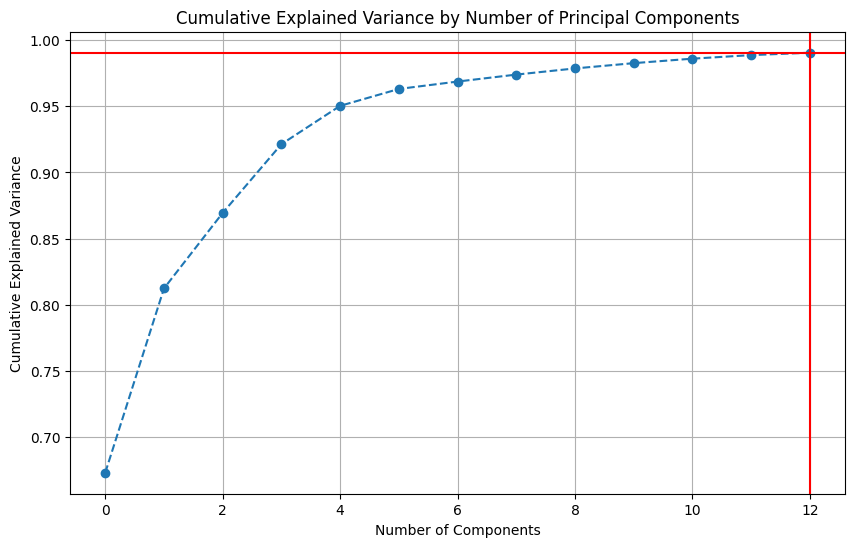

Number of components required to explain 99.0% variance: 17 morl


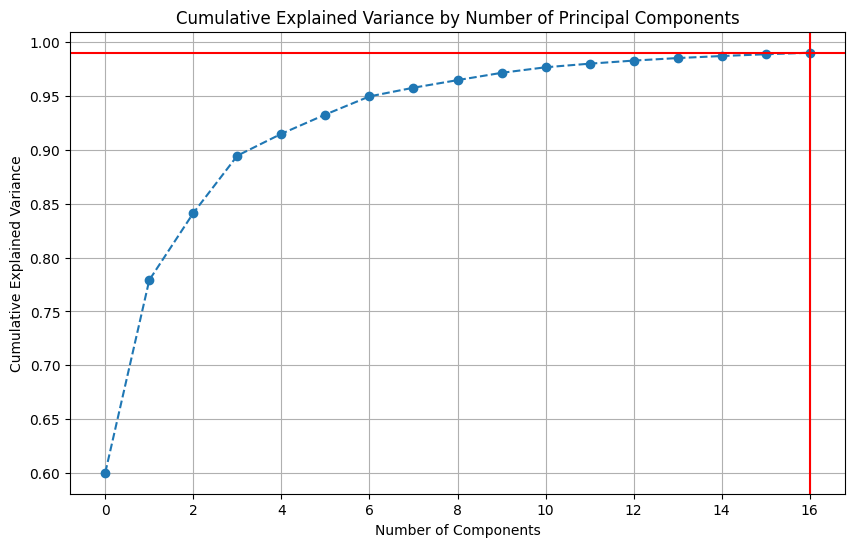

Number of components required to explain 99.0% variance: 10 gaus1


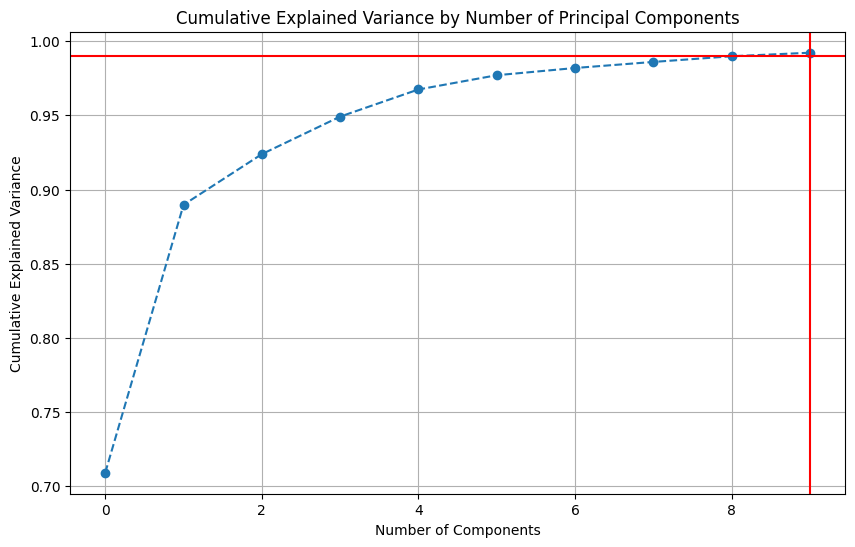

Number of components required to explain 99.0% variance: 12 gaus2


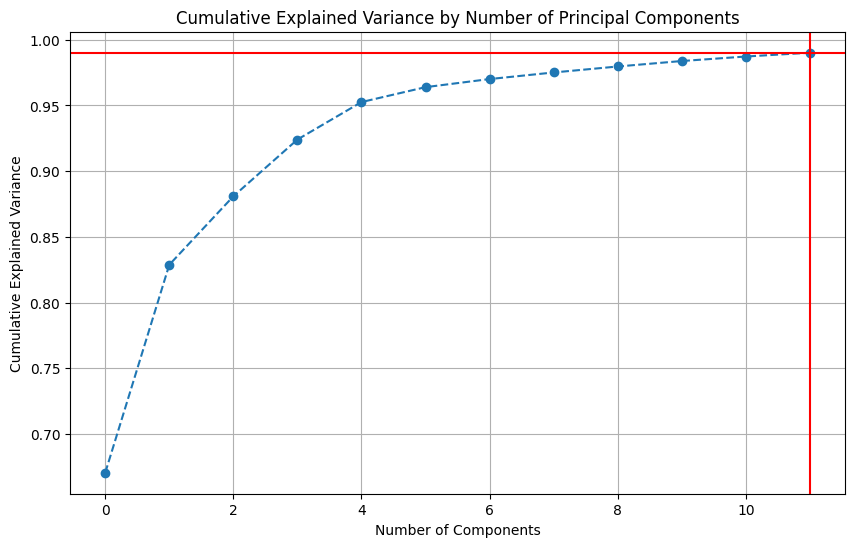

In [14]:
for wavelet in waveletTypes:
    pca = PCA(0.99)
    pca.fit(train_window_data[wavelet])
    train_window_data[wavelet] = pca.transform(train_window_data[wavelet])
    test_window_data[wavelet] = pca.transform(test_window_data[wavelet])

    # Assuming X is your data
    # pca = PCA()
    # pca.fit(train_window_data[wavelet])

    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components where the cumulative explained variance meets or exceeds the threshold
    threshold = 0.99
    num_components = np.argmax(cumulative_explained_variance >= threshold) + 1

    # Print the number of components
    print(f"Number of components required to explain {threshold*100}% variance: {num_components} " + wavelet)

    # Plot cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance by Number of Principal Components')
    plt.axhline(y=threshold, color='r', linestyle='-')
    plt.axvline(x=num_components-1, color='r', linestyle='-')
    plt.grid(True)
    plt.show()

In [15]:
np.shape(test_window_data['mexh'])

(99022, 13)

In [16]:
def print_score(clf,  X_test, y_test):
    '''
    print the accuracy score, classification report and confusion matrix of classifier
    '''

    '''
    test performance
    '''
    print("Test Result:\n")        
    print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
    print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test), digits=5)))
    cm = confusion_matrix(y_test, clf.predict(X_test))
    print(cm)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the parameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'splitter': ['best', 'random']
}

cart_clf = {}

for wavelet in waveletTypes:
    print(f"Training on wavelet: {wavelet}")
    
    # Initialize a GridSearchCV with DecisionTreeClassifier and the parameter grid
    clf = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, cv=5, scoring='accuracy')
    
    # Fit the model
    clf.fit(train_window_data[wavelet], train_window_labels[wavelet])
    
    # Get the best estimator
    cart_clf[wavelet] = clf.best_estimator_
    
    # Evaluate the model
    predictions = cart_clf[wavelet].predict(test_window_data[wavelet])
    accuracy = accuracy_score(test_window_labels[wavelet], predictions)
    print(f"Best Parameters: {clf.best_params_}")
    print(f"Accuracy: {accuracy:.4f}\n")


In [17]:
from sklearn.tree import DecisionTreeClassifier

cart_clf = {}

for wavelet in waveletTypes:
    print(wavelet)
    cart_clf[wavelet] = DecisionTreeClassifier(criterion='entropy',max_features = 'sqrt',random_state = 0,max_depth=5,min_samples_leaf=1,splitter = 'best')
    cart_clf[wavelet].fit(train_window_data[wavelet], train_window_labels[wavelet])
    print_score(cart_clf[wavelet], test_window_data[wavelet], test_window_labels[wavelet])


    # print_score(cart_clf, X_train, y_train, X_test, y_test, train = False)

mexh
Test Result:

accuracy score: 0.7198

Classification Report: 
               precision    recall  f1-score   support

           0    0.88962   0.86455   0.87691     50697
           1    0.58511   0.45474   0.51175     25164
           2    0.52999   0.69099   0.59987     23161

    accuracy                        0.71981     99022
   macro avg    0.66824   0.67009   0.66284     99022
weighted avg    0.72812   0.71981   0.71931     99022


[[43830  4119  2748]
 [ 2276 11443 11445]
 [ 3162  3995 16004]]
morl
Test Result:

accuracy score: 0.6542

Classification Report: 
               precision    recall  f1-score   support

           0    0.83386   0.85082   0.84226     50697
           1    0.43379   0.42752   0.43063     25164
           2    0.48408   0.47014   0.47701     23161

    accuracy                        0.65421     99022
   macro avg    0.58391   0.58283   0.58330     99022
weighted avg    0.65038   0.65421   0.65222     99022


[[43134  4726  2837]
 [ 5638 10758  

In [18]:
for wavelet, model in cart_clf.items():
    with open("ml_models/cart_clf_" + wavelet + '.pkl', 'wb') as file:
        pickle.dump(model, file)

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [7, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 5],
    'max_features': ['sqrt', 'log2']
}
param_grid = {
    'n_estimators': [300],
    'criterion': ['entropy'],
    'max_depth': [20],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}
# Best parameters found:  {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}

rf_clf = {}
for wavelet in waveletTypes:
    # Instantiate the RandomForestClassifier
    rf_clf[wavelet] = RandomForestClassifier(random_state=0, bootstrap=True)

    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator=rf_clf[wavelet], param_grid=param_grid, 
                            cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

    # Fit the grid search to the data
    grid_search.fit(train_window_data[wavelet], np.array(train_window_labels[wavelet]).ravel())

    # Print the best parameters found by the grid search
    print("Best parameters found: ", grid_search.best_params_)

    # Use the best estimator
    rf_clf[wavelet] = grid_search.best_estimator_

    print_score(rf_clf[wavelet], test_window_data[wavelet], test_window_labels[wavelet])

for wavelet, model in rf_clf.items():
    with open("ml_models/rf_optimized_clf_" + wavelet + '.pkl', 'wb') as file:
        pickle.dump(model, file)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, n_estimators=300; total time= 5.1min
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, n_estimators=300; total time= 5.1min
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, n_estimators=300; total time= 5.1min
Best parameters found:  {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}
Test Result:

accuracy score: 0.7232

Classification Report: 
               precision    recall  f1-score   support

           0    0.91987   0.89258   0.90602     50697
           1    0.54409   0.42541   0.47749     25164
           2    0.51914   0.67588   0.58723     23161

    accuracy                        0.72317     99022
   macro avg    0.66103   0.66462   0.65691     99022
weighted avg    0.73064   0.72317   0.72255     99022


[[45251 

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_clf1 = {}
for wavelet in waveletTypes:
    rf_clf1[wavelet] = RandomForestClassifier(n_estimators = 100,criterion='entropy',max_features = 'sqrt',random_state = 0,max_depth=7,min_samples_leaf=2)
    rf_clf1[wavelet].fit(train_window_data[wavelet], np.array(train_window_labels[wavelet]).ravel())
    print_score(rf_clf1[wavelet], test_window_data[wavelet], test_window_labels[wavelet])

Test Result:

accuracy score: 0.7324

Classification Report: 
               precision    recall  f1-score   support

           0    0.92237   0.89082   0.90632     50697
           1    0.57477   0.41591   0.48260     25164
           2    0.53061   0.72967   0.61442     23161

    accuracy                        0.73244     99022
   macro avg    0.67592   0.67880   0.66778     99022
weighted avg    0.74241   0.73244   0.73037     99022


[[45162  2780  2755]
 [ 2503 10466 12195]
 [ 1298  4963 16900]]
Test Result:

accuracy score: 0.6325

Classification Report: 
               precision    recall  f1-score   support

           0    0.83900   0.86181   0.85025     50697
           1    0.38567   0.32868   0.35490     25164
           2    0.41845   0.46073   0.43858     23161

    accuracy                        0.63252     99022
   macro avg    0.54771   0.55041   0.54791     99022
weighted avg    0.62543   0.63252   0.62808     99022


[[43691  3918  3088]
 [ 5151  8271 11742]
 [ 3

In [ ]:
for wavelet, model in rf_clf.items():
    with open("ml_models/rf_clf_" + wavelet + '.pkl', 'wb') as file:
        pickle.dump(model, file)

#### Accuracy Metrics and Confusion Matrix

In [ ]:
svm_clf = {}

for wavelet in waveletTypes:
    print('----------------',wavelet)
    X_train = train_window_data[wavelet]
    if len(X_train) > 0:
        X_test = test_window_data[wavelet]
        y_train = train_window_labels[wavelet]
        y_test = test_window_labels[wavelet]
        
        sc = StandardScaler()
        mm_sc = MinMaxScaler()
        sc.fit(X_train)
        X_train_sc = sc.transform(X_train)
        X_test_sc = sc.transform(X_test)

        mm_sc.fit(X_train)
        X_train_mm_sc = mm_sc.transform(X_train)
        X_test_mm_sc = mm_sc.transform(X_test)
        svm_clf[wavelet] = svm.SVC(kernel='linear',decision_function_shape = 'ovr',gamma='auto',random_state=0, C = 2.0,verbose=True)
        svm_clf[wavelet].fit(X_train_mm_sc, y_train)
        print_score(svm_clf[wavelet], X_train_mm_sc, y_train, X_test_mm_sc, y_test, train = False)

In [ ]:
for wavelet, model in svm_clf.items():
    with open("ml_models/svm_clf_" + wavelet + '.pkl', 'wb') as file:
        pickle.dump(model, file)

In [ ]:
import numpy as np

def calculate_generalized_accuracy(confusion_matrix):
    # Ensure the confusion matrix is a NumPy array
    confusion_matrix = np.array(confusion_matrix)
    
    num_classes = confusion_matrix.shape[0]
    accuracies = []

    for i in range(num_classes):
        TP = confusion_matrix[i, i]
        FN = np.sum(confusion_matrix[i, :]) - TP
        FP = np.sum(confusion_matrix[:, i]) - TP
        TN = np.sum(confusion_matrix) - (TP + FN + FP)
        
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        accuracies.append(accuracy)
    
    average_accuracy = np.mean(accuracies)
    return average_accuracy

# Example usage
confusion_matrix = [[89748,  3174,  3657],
 [25793,  5463,  5474],
 [ 8180,  3456,  8405]]
average_accuracy = calculate_generalized_accuracy(confusion_matrix)
print(f"Average accuracy: {average_accuracy:.4f}")

In [ ]:
from scipy.stats import mode

def ensemble_predict(models, data):
    # Collect the predictions and their probabilities from each model
    all_preds = np.zeros((len(models), data.shape[0]), dtype=int)
    all_probs = np.zeros((len(models), data.shape[0], models[0].predict_proba(data).shape[1]))
    
    for i, model in enumerate(models):
        all_preds[i] = model.predict(data)
        all_probs[i] = model.predict_proba(data)
    
    # Compute the mode of the predictions along the first axis
    final_preds, counts = mode(all_preds, axis=0)
    
    # Flatten the final_preds array to get a 1D array
    final_preds = final_preds.flatten()
    
    # Check for ties and apply tie-breaking strategy
    for i in range(len(final_preds)):
        if counts[0, i] == 1:  # All predictions are different
            # Get the classes predicted by each model for this sample
            class_preds = all_preds[:, i]
            
            # Get the corresponding probabilities for these classes
            class_probs = np.array([all_probs[j, i, class_preds[j]] for j in range(len(models))])
            
            # Choose the class with the highest confidence
            final_preds[i] = class_preds[np.argmax(class_probs)]
    
    return final_preds

In [ ]:
models = []
wavelet = 'mexh'

with open("ml_models/cart_clf_" + wavelet + '.pkl', 'rb') as file:
    models.append(pickle.load(file))
with open("ml_models/rf_clf_" + wavelet + '.pkl', 'rb') as file:
    models.append(pickle.load(file))
# with open("ml_models/svm_clf_" + wavelet + '.pkl', 'rb') as file:
#     models.append(pickle.load(file))

ensemble_predict(models, test_window_data[wavelet])
print("Test Result:\n")        
print("accuracy score: {0:.4f}\n".format(accuracy_score(test_window_labels[wavelet], ensemble_predict(models, test_window_data[wavelet]))))
print("Classification Report: \n {}\n".format(classification_report(test_window_labels[wavelet], ensemble_predict(models, test_window_data[wavelet]))))
cm = confusion_matrix(test_window_labels[wavelet], ensemble_predict(models, test_window_data[wavelet]))
print(cm)

END

**Signed By:**

Muiz Alvi <br><br>
Adil Jowad Qureshi